In [2]:
# ! pip install shap

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.model_selection import GridSearchCV # for hyperparameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
)
import warnings 
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
df = pd.read_csv("customer_churn_data.csv")

In [5]:
df.head(10)

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes
5,6,42,Female,16,119.75,Two-Year,DSL,1916.00,Yes,Yes
6,7,60,Male,14,80.32,One-Year,NaN,1124.48,No,Yes
7,8,52,Female,6,58.90,One-Year,NaN,353.40,No,Yes
8,9,40,Female,53,49.81,Two-Year,Fiber Optic,2639.93,Yes,No
9,10,50,Female,10,61.55,Month-to-Month,Fiber Optic,615.50,Yes,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [7]:
# checking for missing values
df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64

In [8]:
df["InternetService"]

0      Fiber Optic
1      Fiber Optic
2      Fiber Optic
3              DSL
4              NaN
          ...     
995    Fiber Optic
996            NaN
997    Fiber Optic
998            NaN
999            NaN
Name: InternetService, Length: 1000, dtype: object

In [9]:
df["InternetService"].value_counts()

InternetService
Fiber Optic    395
DSL            308
Name: count, dtype: int64

In [10]:
# fill the nan values in InternetService column with "No Internet"
df["InternetService"] = df["InternetService"].fillna("No Internet")

In [11]:
df.isna().sum()

CustomerID         0
Age                0
Gender             0
Tenure             0
MonthlyCharges     0
ContractType       0
InternetService    0
TotalCharges       0
TechSupport        0
Churn              0
dtype: int64

In [12]:
# checking for duplicate values
df.duplicated().sum()

np.int64(0)

In [13]:
df.describe()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000


In [14]:
numeric_cols_data = df.select_dtypes(include=['int64', 'float64'])
numeric_cols_data

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
0,1,49,4,88.35,353.40
1,2,43,0,36.67,0.00
2,3,51,2,63.79,127.58
3,4,60,8,102.34,818.72
4,5,42,32,69.01,2208.32
...,...,...,...,...,...
995,996,42,41,37.14,1522.74
996,997,62,9,80.93,728.37
997,998,51,15,111.72,1675.80
998,999,39,68,65.67,4465.56


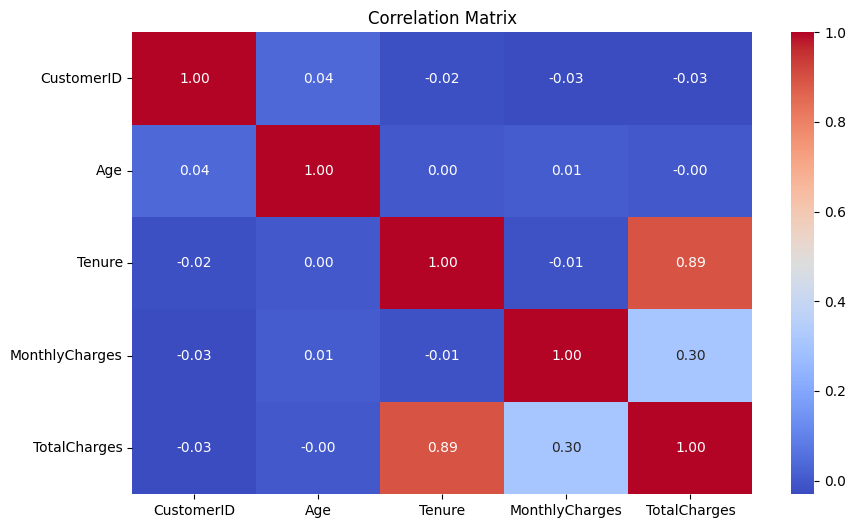

In [15]:
# visualizing the correlation matrix
corr_matrix = numeric_cols_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The correlation value is really low except the TotalCharges and Tenure

In [16]:
df["Churn"].value_counts()

Churn
Yes    883
No     117
Name: count, dtype: int64

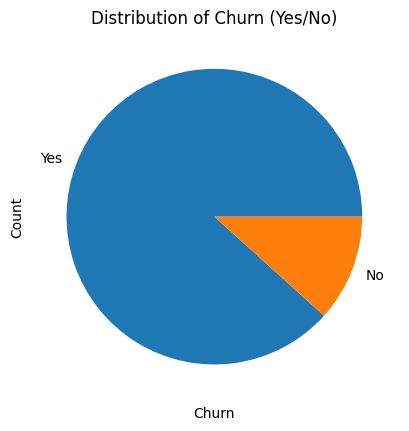

In [17]:
# plot the distribution of target variable
df["Churn"].value_counts().plot(kind="pie")
plt.title("Distribution of Churn (Yes/No)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

In [18]:
df_pie = df.groupby(['Gender', 'Churn']).size().reset_index(name='Count')
fig = px.pie(df_pie, values='Count', names='Churn',
             facet_col='Gender',
             title='Churn Distribution by Gender')
fig.update_layout(
    width=800,
    height=400
)
fig.show()

In [19]:
fig=px.box(df,x='Churn',y='Tenure',color='Churn',title='Tenure vs Churn')
fig.update_layout(
    width=800,
    height=400
)
fig.show()

1. The boxplot shows that customers who churn have lower tenure compared to those who do not churn.
2. The dots shows the customer with long tenure who still churned. That is real life behaviour so we need not remove them.

In [20]:
df_ct = df.groupby(['ContractType', 'Churn']).size().reset_index(name='Count')
# Grouped bar chart
fig = px.bar(
    df_ct,
    x='ContractType',
    y='Count',
    color='Churn',
    barmode='group',
    title='Churn Comparison by Contract Type'
)
fig.update_layout(
    width=800,
    height=400
)

fig.show()

Customer with month-to-month contract are 100% likely to churn than customers with one and two year contract.

In [21]:
df_ts = df.groupby(['TechSupport', 'Churn']).size().reset_index(name='Count')
# Grouped bar chart
fig = px.bar(
    df_ts,
    x='TechSupport',
    y='Count',
    color='Churn',
    barmode='group',
    title='Churn Comparison by Tech Support'
)
fig.update_layout(
    width=800,
    height=400
)

fig.show()

Customer with no tech support are very likely to churn than customer with tech support.

In [23]:
# average MonthlyCharges for churned and non-churned customers
df.groupby("Churn")["MonthlyCharges"].mean()

Churn
No     62.54641
Yes    75.96077
Name: MonthlyCharges, dtype: float64

In [24]:
# average Tenure for churned and non-churned customers
df.groupby("Churn")["Tenure"].mean()

Churn
No     30.264957
Yes    17.476784
Name: Tenure, dtype: float64

In [25]:
# average Age for churned and non-churned customers
df.groupby("Churn")["Age"].mean()

Churn
No     43.487179
Yes    44.831257
Name: Age, dtype: float64

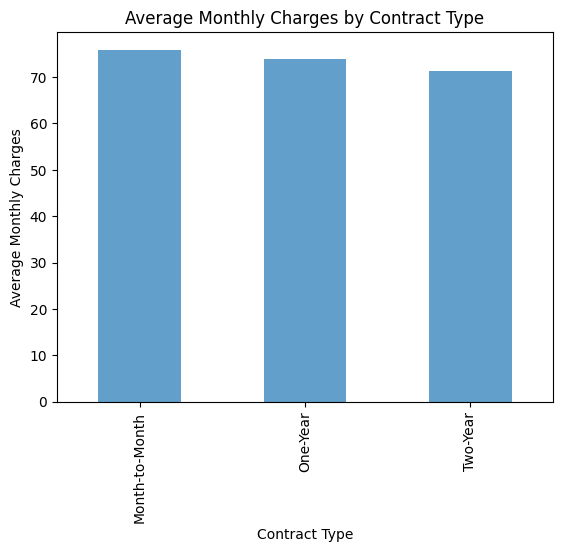

In [26]:
# average MonthlyCharges for churned and non-churned customers by ContractType
df.groupby("ContractType")["MonthlyCharges"].mean().plot(kind="bar", alpha=0.7)
plt.title("Average Monthly Charges by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Average Monthly Charges")
plt.show()

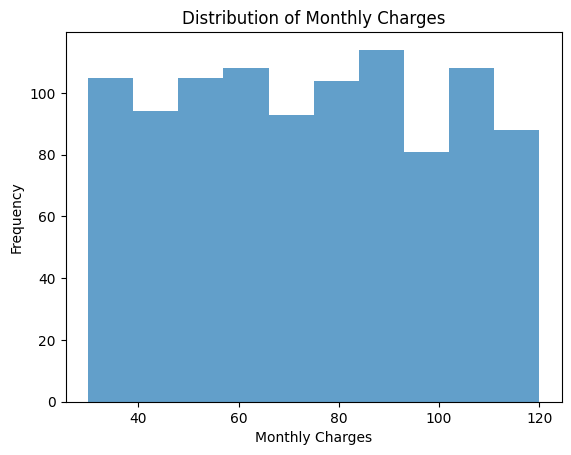

In [27]:
# histogram for MonthlyCharges
plt.hist(df["MonthlyCharges"] ,alpha=0.7)
plt.title("Distribution of Monthly Charges")
plt.xlabel("Monthly Charges")
plt.ylabel("Frequency")
plt.show()

The data for monthly charges is spread out. It can be better to learn if "high charges" correlated with "high churn" versus "low charges".

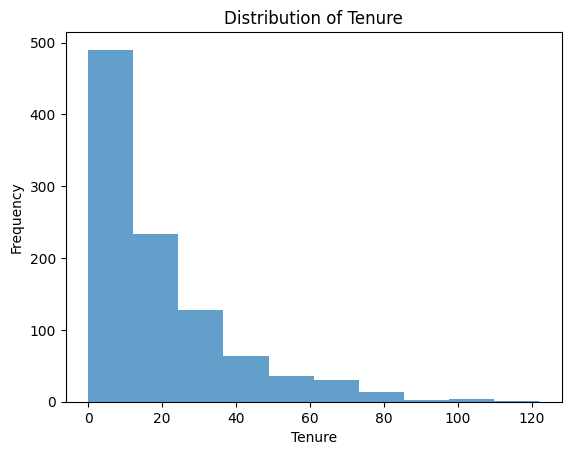

In [28]:
# histogram for Tenure
plt.hist(df["Tenure"] ,alpha=0.7)
plt.title("Distribution of Tenure")
plt.xlabel("Tenure")
plt.ylabel("Frequency")
plt.show()

The dataset contains mostly new customers as the tenure values are between 0 to 20 months.
This right-skewed distribution indicates that customer churn early in the customer lifecycle or they leave quickly while only few remain long term.

In [29]:
df.drop_duplicates(inplace=True)

# binary mapping Gender and Churn columns
df["Gender"] = df["Gender"].map({"Female": 1, "Male": 0})
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [30]:
# drop unnecessary columns
# we don't need customerID because it's just an identifier
# we don't need TotalCharges because it's highly correlated with MonthlyCharges and Tenure because TotalCharges = MonthlyCharges * Tenure
df_model = df.drop(['CustomerID', 'TotalCharges'], axis=1)

In [31]:
df_model.head(2)

,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TechSupport,Churn
0,49,0,4,88.35,Month-to-Month,Fiber Optic,Yes,1
1,43,0,0,36.67,Month-to-Month,Fiber Optic,Yes,1


In [32]:
# one hot encoding the categorical columns
categorical_cols = df_model.select_dtypes(include=['object']).columns
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True, dtype=int)

In [33]:
df_model.head()

,Age,Gender,Tenure,MonthlyCharges,Churn,ContractType_One-Year,ContractType_Two-Year,InternetService_Fiber Optic,InternetService_No Internet,TechSupport_Yes
0,49,0,4,88.35,1,0,0,1,0,1
1,43,0,0,36.67,1,0,0,1,0,1
2,51,1,2,63.79,1,0,0,1,0,0
3,60,1,8,102.34,1,1,0,0,0,1
4,42,0,32,69.01,1,0,0,0,1,0


In [34]:
df_model.shape

(1000, 10)

In [35]:
# separating numerical and categorical features
num_features = ['Age', 'Tenure', 'MonthlyCharges']
cat_features = [
    'Gender',
    'ContractType_One-Year',
    'ContractType_Two-Year',
    'InternetService_Fiber Optic',
    'InternetService_No Internet',
    'TechSupport_Yes'
]

In [36]:
# Define X and y
X = df_model.drop(['Churn', 'ContractType_One-Year', 'ContractType_Two-Year'], axis=1)
# we will drop Contract Type as it will function as proxy for the target variable
y = df_model['Churn'] # target variable

Contract Type created a structural barrier keeping the customer from leaving unless they pay penalty. So a customer with 2 year contract is legally bound to stay and the model will memorize that pattern. so it is better to drop it.

Train Test Split

In [37]:
# 'stratify=y' ensures the Test set has the same % of Churners as the Training set
X_train, X_test, y_train, y_test = train_test_split(
                                X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
# Scaling Numerical Features
scaler  = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

In [39]:
# exporting the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [40]:
print(f"Training Data Shape: {X_train_scaled.shape}")
print(f"Test Data Shape: {X_test_scaled.shape}")

Training Data Shape: (800, 7)
Test Data Shape: (200, 7)


In [41]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Print Metrics
    print(f"{model_name} Performance")
    print(f"Accuracy:{acc:.4f}")
    print(f"Precision:{prec:.4f}")
    print(f"Recall:{rec:.4f}")
    print(f"F1 Score:{f1:.4f}")
    print(f"ROC-AUC:{auc:.4f}")
    print("\nConfusion Matrix:")
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    return {'Model': model_name, 'Recall': rec, 'F1': f1, 'AUC': auc}

# List to store results for comparison
results = []

In [42]:
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

Logistic Regression Performance
Accuracy:0.8300
Precision:0.9931
Recall:0.8136
F1 Score:0.8944
ROC-AUC:0.9148

Confusion Matrix:


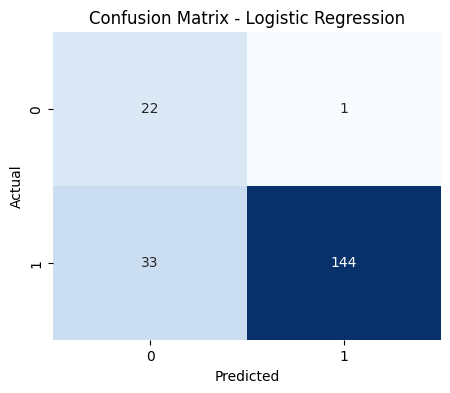

In [43]:
# Evaluate
res_lr = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
results.append(res_lr)

In [44]:
# Model: Random Forest Classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [45]:
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : t

In [46]:
best_rf = grid_rf.best_estimator_
best_rf

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

Random Forest Classifier Performance
Accuracy:0.8950
Precision:0.9937
Recall:0.8870
F1 Score:0.9373
ROC-AUC:0.9590

Confusion Matrix:


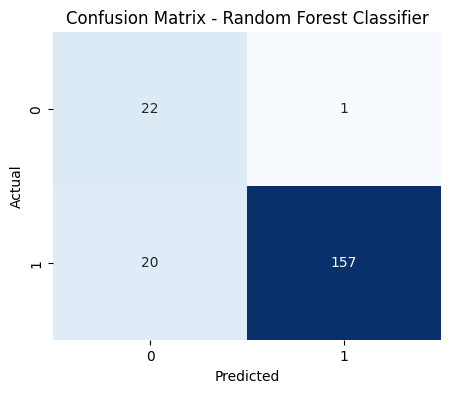

In [47]:
# Evaluate
res_rf = evaluate_model(best_rf, X_test_scaled, y_test, "Random Forest Classifier")
results.append(res_rf)

In [48]:
# Decision Tree
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

In [49]:
grid_dt = GridSearchCV(dt, param_grid_dt, cv=3, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;

In [50]:
best_dt = grid_dt.best_estimator_

Decision Tree Performance
Accuracy:0.8950
Precision:1.0000
Recall:0.8814
F1 Score:0.9369
ROC-AUC:0.9407

Confusion Matrix:


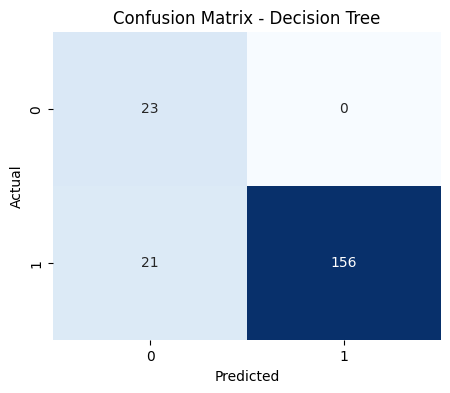

In [51]:
# Evaluate
res_dt = evaluate_model(best_dt, X_test_scaled, y_test, "Decision Tree")
results.append(res_dt)

In [52]:
# comparing the models
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by=['Recall', 'AUC', 'F1'], ascending=False)
print("Final Model Comparison:")
display(comparison_df)

Final Model Comparison:


,Model,Recall,F1,AUC
1,Random Forest Classifier,0.887006,0.937313,0.958978
2,Decision Tree,0.881356,0.936937,0.940678
0,Logistic Regression,0.813559,0.894410,0.914763


In [53]:
# save the feature names for later use in the app
joblib.dump(X_train_scaled.columns.tolist(), 'feature_names.pkl')

['feature_names.pkl']

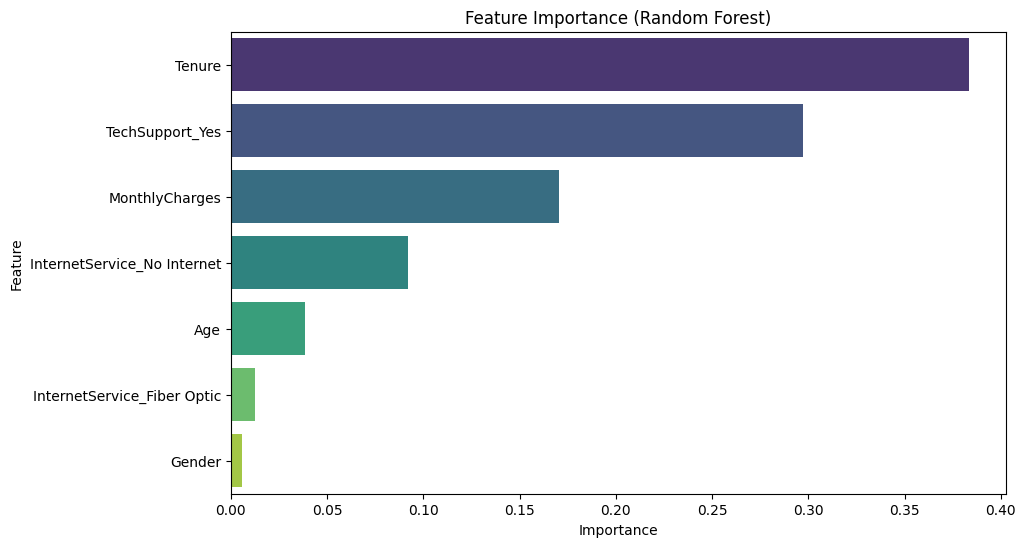

In [54]:
# see what features are important in the Random Forest model
importances = best_rf.feature_importances_
feature_names = X_train_scaled.columns

# creating a datafram to visualize this feature importance
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.show()

This shows that Tenure, Tech Support and Monthly charges are top factors determining the output.

Shap Explainer

In [55]:
explainer = shap.Explainer(best_rf)
shap_values = explainer(X_test_scaled)

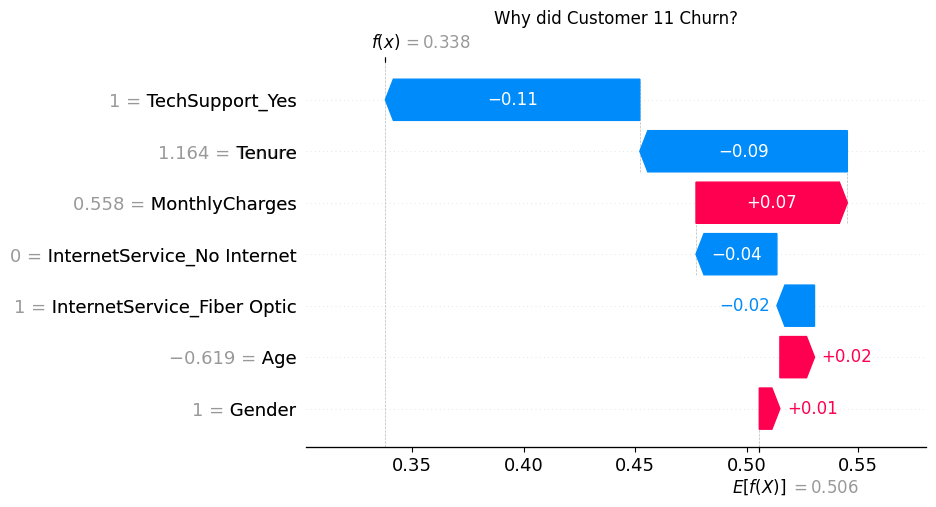

In [56]:
# to know the reason for churn for a specific customer
row_to_show = 11

# Plot for Customer #5
plt.title(f"Why did Customer {row_to_show} Churn?")
shap.plots.waterfall(shap_values[row_to_show, :, 1])

In [57]:
joblib.dump(best_rf, "best_model.pkl")

['best_model.pkl']